# Projet : Reflector imaging from ambient noise signals

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.integrate import quad

In [2]:
def simulated_sampling(N = 200):
    ys = np.vstack((np.random.uniform(-50,50, N),np.random.uniform(-10,10, N),np.random.uniform(185,200, N)))
    return ys.T

def receivers_sampling(n = 5):
    x = np.zeros((n,3))
    x[:,0] = np.arange(n)* 7.5 - 30
    x[:,2] = 100 * np.ones(n)
    return x

### 2) Preliminaries 

In [3]:
c0 = 1 
xr = -5 
yr = 0
zr = np.array([-5,0,65])
sigmar = 1e-3

In [4]:
y = simulated_sampling()
x = receivers_sampling()

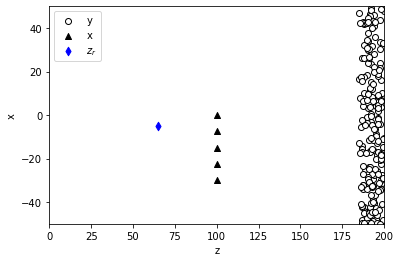

In [5]:
plt.scatter(y[:,2], y[:,0], marker ='o', color = 'white', edgecolors = 'black', label = 'y')
plt.scatter(x[:,2], x[:,0], marker = '^', color ='black', label ='x')
plt.scatter(zr[2], zr[0], marker = 'd', color = 'b', label = r'$z_r$')
plt.xlabel("z")
plt.xlim(0,200)
plt.ylim(-50,50)
plt.ylabel("x")
plt.legend()
plt.show()

### 4) Questions 

In [6]:
def power_spectral_density(omega):
    return np.exp(-np.power(omega,2))

def homogeneous_green_function(omega,x,y):
    if len(x.shape)==1 and len(y.shape)==1 :
        z = np.linalg.norm(x-y)
    else : 
        z = np.linalg.norm(x-y, axis = 1)
    return 1/(4*np.pi*z)*np.exp(1j * omega * z /c0)

def green_function(omega, x, y):
    G = homogeneous_green_function
    return G(omega,x,y) + sigmar * np.power(omega,2)*G(omega,x,zr)*G(omega,zr,y)


def expectation_cross_correlation(tau, x1, x2,y, a = -10, b = 10, n = 1000):    
    omega = np.linspace(a, b, n).reshape(-1,1)
    G_hat_G = np.conj(green_function(omega, x1, y)) * green_function(omega, x2, y)
    C_N = np.dot(power_spectral_density(omega).T,G_hat_G.mean(1))*np.exp(-1j*omega*tau)
    
    # Intégrale de Riemann
    C_N = (b-a)*C_N.mean(0)
    return C_N/(2*np.pi)

/Users/macrafa/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


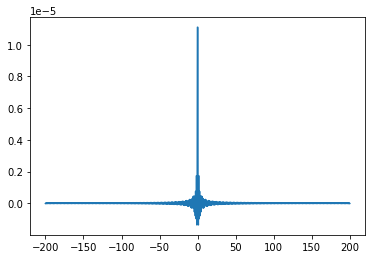

In [7]:
tau = np.linspace(-200,200,1000)

f = expectation_cross_correlation(tau,x[4],x[0],y)
plt.plot(tau, f)
plt.show()

In [8]:
window_size = 20
line = np.arange(-window_size//2,window_size//2)
y_S = zr + [0, 0, 1] * line.reshape(-1,1) + [1, 0, 0] * line.reshape(-1,1,1)

In [9]:
def KM_images(y_S, x, y):
    L = x.shape[0]
    a = y_S.shape[0]
    
    image = np.zeros((a,a))
    for s in range(a):
        I_N = 0
        for j in range(L):
            for l in range(L):
                tau1 = np.linalg.norm(x[j]-y_S[s,:], axis = 1)
                tau2 = np.linalg.norm(x[l]-y_S[s,:], axis = 1)
                
                I_N += expectation_cross_correlation(tau1 + tau2, x[j],x[l],y)
        image[s,:] = I_N.real

    return image

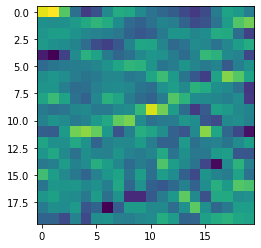

In [10]:
Image = KM_images(y_S, x, y)
plt.imshow(Image)
plt.show()

#### Resolution 

In [11]:
def resolution(img):
    img = np.power(img, 2)
    R = np.max(img)/np.mean(img)
    return R

In [12]:
R = resolution(Image)
print("Resolution de l'image KM de I_N : " + str(R))

Resolution de l'image KM de I_N : 13.767530087818454


#### 2.a

In [13]:
tau = np.linspace(-150,150,1000)



In [ ]:
def empirical_cross_correlation(tau, T, x1, x2, y, a = -10, b = 10, n = 1000): 
    

In [14]:
def C_TNM(M, tau, x_1, x_2, T, y, c_0, z_r, sigma_r, non_direct=False):
	"""
	This function computes an average empirical cross correlation of the signals recorded at two
	distinct locations up to time T
	Args:
		M (int): number of realizations to use for the average
		tau (float): temporal lag
		x_1 (np.array): position of the first recepter
		x_2 (np.array): position of the second recepter
		T (float): time maximum
		y (np.array): position of noise sources
		c_0 (float): celerity
		z_r (np.array): reflector position
		sigma_r (float): multiplicative constant of Taylors second order term
		non_direct (bool, optional): if true return the correlation between a direct wave and a reflected 
						one without taking into account the correlation between the direct waves
	Output:
		C_TNM (np.array): same shape as tau. Correlation
	"""
	# Complexité O(T * M * (N + log T + n_tau))
	output = np.zeros(tau.shape, float)
	mi_tau = min(0, tau.min()-1)
	omega, dt = get_omega(T, mi_tau)
	nt = len(omega)
	t0 = int(-mi_tau/dt)
	l0 = -mi_tau/dt - t0
	if non_direct:
		G1_r = sigma_r * omega[:,None]**2 * hat_G0(omega[:,None],x_1,z_r,c_0) * hat_G0(omega[:,None],z_r,y,c_0)
		G2_r = sigma_r * omega[:,None]**2 * hat_G0(omega[:,None],x_2,z_r,c_0) * hat_G0(omega[:,None],z_r,y,c_0)
		G1_d = hat_G0(omega[:,None],x_1,y,c_0)
		G2_d = hat_G0(omega[:,None],x_2,y,c_0)
		G1s, G2s = [G1_r, G1_d], [G2_d, G2_r]
	else:
		G1s = [hat_G(omega[:,None], x_1, y, c_0, z_r, sigma_r)]
		G2s = [hat_G(omega[:,None], x_2, y, c_0, z_r, sigma_r)]
	for m in range(M):
		print(f'\rRealization: {m+1}/{M}', end='')
		n = hat_n(omega, len(y)) * (omega[1] - omega[0])
		for G1, G2 in zip(G1s, G2s):
			Gn1 = (G1 * n).sum(1) / (2*np.pi*np.sqrt(len(y)))	# sum over y
			Gn2 = (G2 * n).sum(1) / (2*np.pi*np.sqrt(len(y)))	# sum over y
			u1 = np.fft.fft(np.fft.ifftshift(Gn1)).real
			u2 = np.fft.fft(np.fft.ifftshift(Gn2)).real
			for i in range(len(tau)):
				t1 = int(abs(tau[i])/dt)
				l1 = abs(tau[i])/dt - t1
				t1 += 1
				u1t = u1[t0:nt-t1]
				num_t = nt-t0-t1
				t2 = t0 + int(nt+tau[i]/dt) - nt
				l2 = t0 + tau[i]/dt - t2
				u2t = (1-l2) * u2[t2:t2+num_t] + l2 * u2[t2+1:t2+1+num_t]
				output[i] += ((u1t * u2t).sum() - l0*u1t[0]*u2t[0] - l1*u1t[-1]*u2t[-1]) / (num_t-l0-l1)

	print('', end='\r')
	return output / M